In [1]:
from spikegadget2nwb.read_spikegadget import get_ephys_folder
import spikeinterface.extractors as se
import os
import numpy as np
import spikeinterface.preprocessing as spre
import time
import spikeinterface as si
from pathlib import Path

c:\Users\Windows\.conda\envs\ms10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
subject_id = "CnL20"
exp_date = "20240811"
exp_time = "144358"
ish = 0
session_description = subject_id + '_' + exp_date + '_' + exp_time + '.rec'
ephys_folder = Path(r"D:\cl\ephys")
# ephys_folder = Path(r"D:\cl\rf_reconstruction\freelymoving")
# ephys_folder = get_ephys_folder()
folder = ephys_folder / session_description

# nwb_file = folder / (session_description + f'sh{ish}.nwb')
nwb_file = folder / (session_description + '.nwb')
rec = se.NwbRecordingExtractor(nwb_file)
rec

NwbRecordingExtractor: 128 channels - 30.0kHz - 1 segments - 7,292,292 samples 
                       243.08s (4.05 minutes) - int16 dtype - 1.74 GiB
  file_path: D:\cl\ephys\CnL20_20240811_144358.rec\CnL20_20240811_144358.rec.nwb

In [3]:
def get_bad_ch_id(rec, folder, load_if_exists=True):
    if load_if_exists and os.path.exists(folder / f'bad_ch_id_sh{ish}.npy'):
        bad_ch_id = np.load(folder / f'bad_ch_id_sh{ish}.npy')
    else:
        bad_ch_id, _ = spre.detect_bad_channels(
            rec, num_random_chunks=400, n_neighbors=5, dead_channel_threshold=-0.2)

        np.save(folder / f'bad_ch_id_sh{ish}.npy', bad_ch_id)

    print('Bad channel IDs:', bad_ch_id)
    return bad_ch_id

In [4]:
rec_filtered = spre.bandpass_filter(rec, freq_min=300, freq_max=6000)
bad_ch_id = get_bad_ch_id(rec_filtered, folder)
remaining_ch = np.array([ch for ch in rec.get_channel_ids() if ch not in bad_ch_id])

# export remaining channel ids to a npy file
np.save(os.path.join(folder, f'remaining_ch_sh{ish}.npy'), remaining_ch)
remaining_ch

Bad channel IDs: [ 5 13 16 17 21 29]


array([  0,   1,   2,   3,   4,   6,   7,   8,   9,  10,  11,  12,  14,
        15,  18,  19,  20,  22,  23,  24,  25,  26,  27,  28,  30,  31,
        32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,
        45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
        58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123, 124, 125, 126, 127])

In [5]:
threshold = 7
chunk_size = 900
n_timepoints = rec_filtered.get_num_frames()
n_channels = rec_filtered.get_num_channels()
num_chunks = int(np.ceil(n_timepoints / chunk_size))

# load artifact indices if exists
if os.path.exists(folder / f'artifact_indices_sh{ish}.npy'):
    artifact_indices = np.load(folder / f'artifact_indices_sh{ish}.npy')
else:
# mask artifacts
    norms = np.zeros((num_chunks, n_channels))
    for i in range(num_chunks):
        start = int(i * chunk_size)
        end = int(np.minimum((i + 1) * chunk_size, n_timepoints))
        chunk = rec_filtered.get_traces(start_frame=start, end_frame=end, return_scaled=True)

        norms[i] = np.linalg.norm(chunk, axis=0)

    
    use_it = np.ones(num_chunks, dtype=bool)
# if detect artifacts in a chunk, don't use it and the two neighboring chunks

    for m in range(n_channels):
        if m in bad_ch_id:
            continue
        vals = norms[:, m]

        sigma0 = np.std(vals)
        mean0 = np.mean(vals)

        artifact_indices = np.where(vals > mean0 + threshold * sigma0)[0]

        # check if the first chunk is above threshold, ensure that we don't use negative indices later
        negIndBool = np.where(artifact_indices > 0)[0]

        # check if the last chunk is above threshold to avoid a IndexError
        maxIndBool = np.where(artifact_indices < num_chunks - 1)[0]

        use_it[artifact_indices] = 0
        use_it[artifact_indices[negIndBool] - 1] = 0  # don't use the neighbor chunks either
        use_it[artifact_indices[maxIndBool] + 1] = 0  # don't use the neighbor chunks either

        print("For channel %d: mean=%.2f, stdev=%.2f, chunk size = %d, n_artifacts = %d" % (m, mean0, sigma0, chunk_size, len(artifact_indices)))


    artifact_indices = np.where(use_it == 0)[0]
    artifact_indices = artifact_indices * chunk_size
    # save artifact indices
    np.save(folder / f'artifact_indices_sh{ish}.npy', artifact_indices)


In [6]:
chunk_time = chunk_size / rec.get_sampling_frequency()*1000

if artifact_indices.size > 0:
    rec_rm_artifacts = spre.remove_artifacts(rec_filtered, list_triggers=artifact_indices, ms_before=0, ms_after=chunk_time)

else:
    rec_rm_artifacts = rec_filtered


# rec_clean = rec_rm_artifacts.channel_slice(remaining_ch)
rec_ref = spre.common_reference(rec_rm_artifacts, reference='global', operator='average')
recording_whitened = spre.whiten(rec_ref, dtype='float32')

In [ ]:
import mountainsort5 as ms5
import json
from tempfile import TemporaryDirectory
from mountainsort5.util import create_cached_recording

experiment_length = rec_ref.get_duration() / 60  # in minutes


threshold = 5.5
phase1_detect_time_radius_msec = .4

    
if experiment_length < 25:
    sorting_params = ms5.Scheme1SortingParameters(
        detect_time_radius_msec=phase1_detect_time_radius_msec, detect_threshold=threshold,
        )
    sorting = ms5.sorting_scheme1(
        recording_whitened, sorting_parameters=sorting_params)
    
    assert isinstance(sorting, si.BaseSorting)
else:
    sorting_params = ms5.Scheme2SortingParameters(
        phase1_detect_threshold=threshold, detect_threshold=threshold,
        phase1_detect_channel_radius=100, detect_channel_radius=100, phase1_detect_time_radius_msec=phase1_detect_time_radius_msec, training_duration_sec=5*60,
        training_recording_sampling_mode='uniform')
    sorting = ms5.sorting_scheme2(
        recording=recording_whitened, sorting_parameters=sorting_params)

Number of channels: 128
Number of timepoints: 7292292
Sampling frequency: 30000.0 Hz
Channel 0: [325.  75.]
Channel 1: [350. 225.]
Channel 2: [350. 175.]
Channel 3: [325. 250.]
Channel 4: [350. 150.]
Channel 5: [325. 225.]
Channel 6: [325. 275.]
Channel 7: [325. 100.]
Channel 8: [350. 350.]
Channel 9: [325. 175.]
Channel 10: [325. 150.]
Channel 11: [350. 375.]
Channel 12: [350. 100.]
Channel 13: [350. 250.]
Channel 14: [350.  50.]
Channel 15: [325. 375.]
Channel 16: [350. 125.]
Channel 17: [350. 300.]
Channel 18: [350.  75.]
Channel 19: [325. 350.]
Channel 20: [325. 325.]
Channel 21: [350.  25.]
Channel 22: [350. 325.]
Channel 23: [  0. 250.]
Channel 24: [ 0. 50.]
Channel 25: [350.   0.]
Channel 26: [0. 0.]
Channel 27: [325. 300.]
Channel 28: [ 0. 25.]
Channel 29: [350. 275.]
Channel 30: [ 25. 225.]
Channel 31: [350. 200.]
Channel 32: [325. 125.]
Channel 33: [325. 200.]
Channel 34: [325.   0.]
Channel 35: [325.  25.]
Channel 36: [ 25. 200.]
Channel 37: [  0. 200.]
Channel 38: [325.  50

In [18]:
current_time = time.strftime("%Y%m%d_%H%M", time.localtime())
folder_name = f'sorting_results_sh{ish}' + current_time
sort_out_folder = folder / folder_name
if not os.path.exists(sort_out_folder):
    os.makedirs(sort_out_folder)

# write a into json file: sorting_params.json
with open(sort_out_folder / 'sorting_params.json', 'w') as f:
    json.dump(sorting_params.__dict__, f)

In [19]:
print(f'unit number:{len(sorting.get_unit_ids())}')

unit number:1


In [20]:
sorting.register_recording(rec_ref)
sorting.save(folder = os.path.join(sort_out_folder, 'sorting'))

c:\Users\Windows\.conda\envs\ms10\lib\site-packages\spikeinterface\core\basesorting.py:264: UserWarning: The registered recording will not be persistent on disk, but only available in memory
  warnings.warn("The registered recording will not be persistent on disk, but only available in memory")


NumpyFolder: 1 units - 1 segments - 30.0kHz

## export sorting result to phy

In [24]:
from spikeinterface import create_sorting_analyzer
from spikeinterface.exporters import export_to_phy


sorting_analyzer_folder = sort_out_folder / 'sorting_analyzer' 

if not os.path.exists(sorting_analyzer_folder):
    sorting_analyzer = create_sorting_analyzer(sorting=sorting, recording=rec_ref, format='memory',)
    
print(sorting_analyzer)
sorting_analyzer.compute("random_spikes")
sorting_analyzer.compute("waveforms", ms_before=2.0, ms_after=2.0)
sorting_analyzer.compute(["templates"])

phy_folder = sort_out_folder / 'ph1'
if not phy_folder.exists():
    phy_folder.mkdir()
export_to_phy(
    sorting_analyzer,
    phy_folder,
    verbose=True,
    remove_if_exists=True,
)

estimate_sparsity: 100%|##########| 1016/1016 [00:00<00:00, 5489.98it/s]


SortingAnalyzer: 32 channels - 1 units - 1 segments - memory - sparse - has recording
Loaded 0 extensions: 


extract PCs: 100%|##########| 1016/1016 [1:04:47<00:00,  3.83s/it]

Run:
phy template-gui  D:\cl\rf_reconstruction\head_fixed\CnL14_20241004_153555.rec\sorting_results_sh020241022_1744\ph1\params.py


(1, 120, 15)


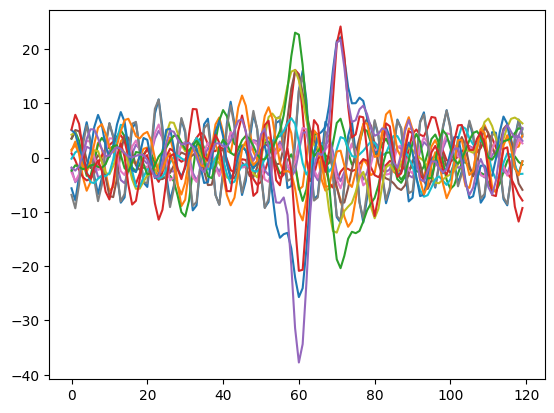

In [8]:
# load template to see what's going on there
# todo: load templates
import numpy as np
import matplotlib.pyplot as plt
template_path = r"D:\cl\rf_reconstruction\head_fixed\CnL14_20241004_153555.rec\sorting_results_sh020241022_1744\ph1\templates.npy"
templates = np.load(template_path)
print(templates.shape)

for i in range(templates.shape[2]):
    plt.plot(templates[0, :, i]/0.195)